Heart Disease Risk Prediction Project

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
warnings.filterwarnings('ignore')

/kaggle/input/heart-disease-risk-prediction-dataset/heart_disease_risk_dataset_earlymed.xls
/kaggle/input/heart-disease-risk-prediction-dataset/heart_disease_risk_dataset_earlymed.csv


In [2]:
df = pd.read_csv("/kaggle/input/heart-disease-risk-prediction-dataset/heart_disease_risk_dataset_earlymed.csv")
df.head()

,Chest_Pain,Shortness_of_Breath,Fatigue,Palpitations,Dizziness,Swelling,Pain_Arms_Jaw_Back,Cold_Sweats_Nausea,High_BP,High_Cholesterol,Diabetes,Smoking,Obesity,Sedentary_Lifestyle,Family_History,Chronic_Stress,Gender,Age,Heart_Risk
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,48.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,46.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,66.0,0.0
3,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,60.0,1.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0


Exploratory Data Analysis & Data Visualization

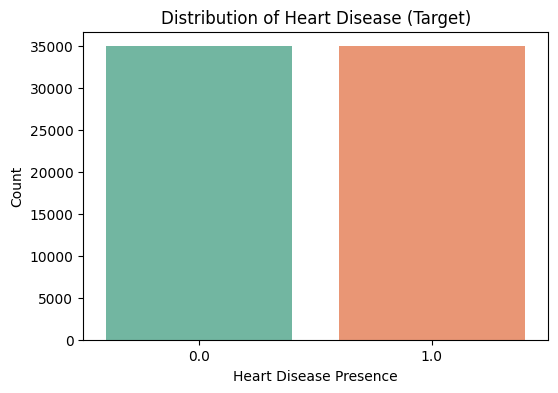

Heart_Risk
0.0    50.0
1.0    50.0
Name: proportion, dtype: float64


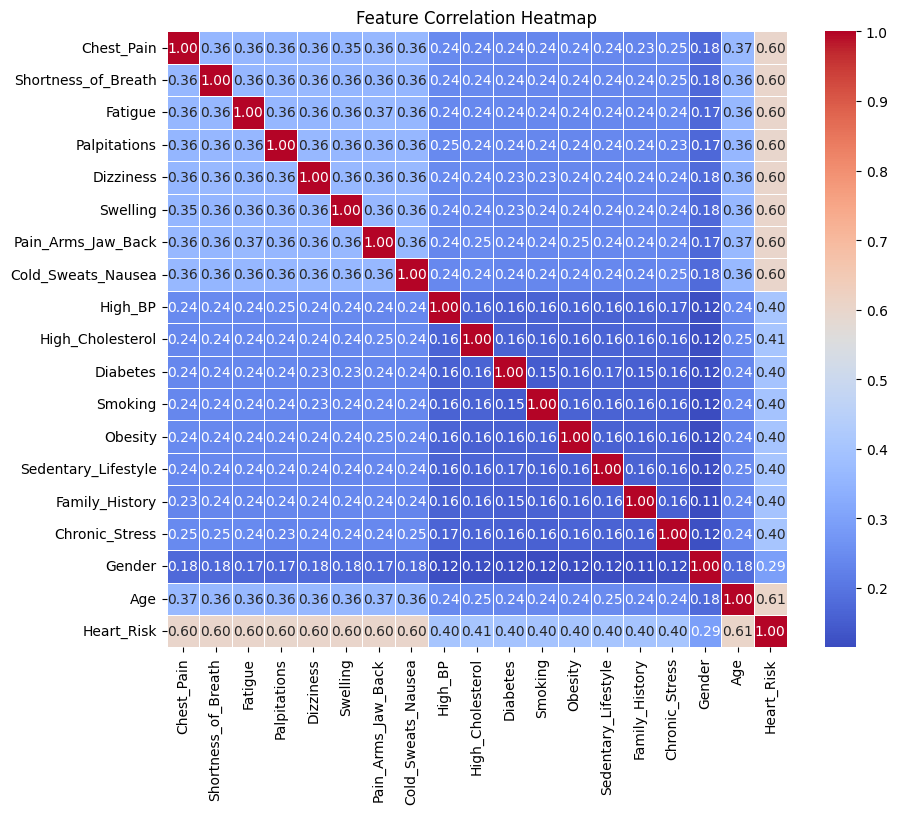

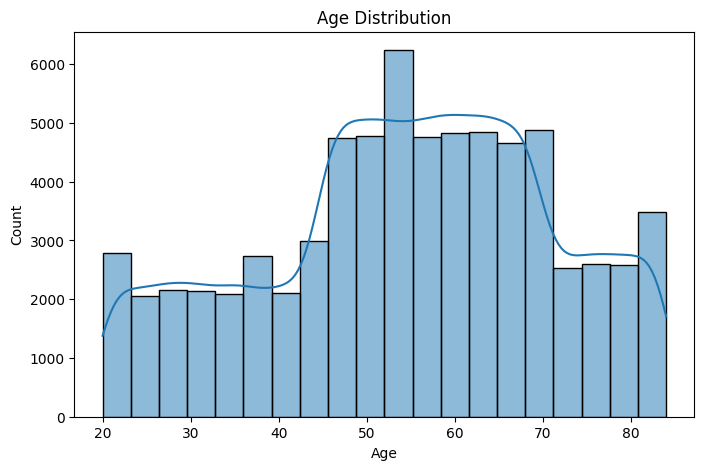

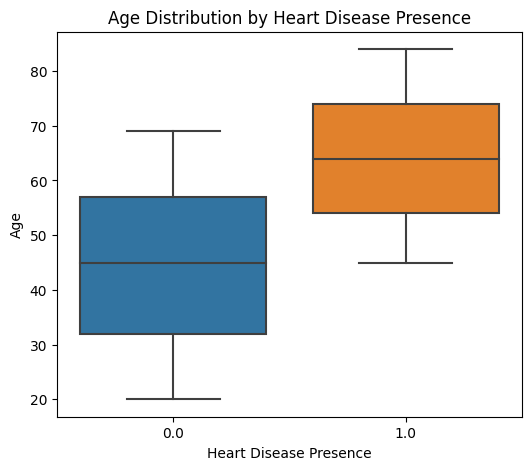

In [3]:
df.isnull().sum()

plt.figure(figsize=(6,4))
sns.countplot(x=df['Heart_Risk'], palette='Set2')
plt.title('Distribution of Heart Disease (Target)')
plt.xlabel('Heart Disease Presence')
plt.ylabel('Count')
plt.show()
print(df['Heart_Risk'].value_counts(normalize=True) * 100)


plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6,5))
sns.boxplot(x=df['Heart_Risk'], y=df['Age'])
plt.title('Age Distribution by Heart Disease Presence')
plt.xlabel('Heart Disease Presence')
plt.ylabel('Age')
plt.show()

Modeling (Logistic Regression, KNN, Random Forest, XGBoost, Neural Network)

In [4]:
# Preprocessing and Split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

X = df.drop(columns=['Heart_Risk'])  
y = df['Heart_Risk'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Original dataset that uses original 'Age', will be used for RF and XGBoost
X_train_original = X_train.copy()
X_test_original = X_test.copy()

# Another dataset that uses scaled 'Age', will be used for baseline models and the NN
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled['Age_scaled'] = scaler.fit_transform(X_train[['Age']])
X_test_scaled['Age_scaled'] = scaler.transform(X_test[['Age']])
X_train_scaled = X_train_scaled.drop(columns=['Age'])
X_test_scaled = X_test_scaled.drop(columns=['Age'])

In [5]:
# Training using F1 score and Auc-Roc
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")

    if name in ["Logistic Regression", "KNN"]:
        X_train_used, X_test_used = X_train_scaled, X_test_scaled  
    else:
        X_train_used, X_test_used = X_train_original, X_test_original 

    if name == "KNN":
        param_grid = {'n_neighbors': list(range(1, 51, 2))}
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
        grid_search.fit(X_train_used, y_train)
        model = grid_search.best_estimator_
        print(f"Best KNN k: {grid_search.best_params_['n_neighbors']}")

    elif name == "Random Forest":
        param_grid = {
            'n_estimators': [100, 300, 500],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 5],
            'criterion': ['gini', 'entropy']
        }
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
        grid_search.fit(X_train_used, y_train)
        model = grid_search.best_estimator_
        print(f"Best RF params: {grid_search.best_params_}")

    elif name == "XGBoost":
        param_grid = {
            'n_estimators': [100, 300, 500],
            'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
            'max_depth': [1, 2, 3, 5],
            'min_child_weight': [3, 5, 7, 9]
        }
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
        grid_search.fit(X_train_used, y_train)
        model = grid_search.best_estimator_
        print(f"Best XGBoost params: {grid_search.best_params_}")

    model.fit(X_train_used, y_train)

    y_pred = model.predict(X_test_used)
    y_pred_proba = model.predict_proba(X_test_used)[:, 1] if hasattr(model, "predict_proba") else None

    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    results[name] = {"F1 Score": f1, "ROC-AUC": roc_auc}

Training Logistic Regression...
Training KNN...
Best KNN k: 49
Training Random Forest...
Best RF params: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training XGBoost...
Best XGBoost params: {'learning_rate': 0.5, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 500}


In [6]:
# NN
X_train_nn, X_test_nn = X_train_scaled, X_test_scaled

scaler_nn = StandardScaler()
X_train_nn = scaler_nn.fit_transform(X_train_nn)
X_test_nn = scaler_nn.transform(X_test_nn)

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_nn.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_nn, y_train, validation_data=(X_test_nn, y_test), epochs=150, batch_size=32, verbose=1)

loss, accuracy = model.evaluate(X_test_nn, y_test)
results["Neural Network"] = {"Accuracy": accuracy}

Epoch 1/150
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9168 - loss: 0.2433 - val_accuracy: 0.9906 - val_loss: 0.0266
Epoch 2/150
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9898 - loss: 0.0303 - val_accuracy: 0.9909 - val_loss: 0.0266
Epoch 3/150
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9907 - loss: 0.0284 - val_accuracy: 0.9909 - val_loss: 0.0264
Epoch 4/150
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9903 - loss: 0.0284 - val_accuracy: 0.9906 - val_loss: 0.0261
Epoch 5/150
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9905 - loss: 0.0282 - val_accuracy: 0.9904 - val_loss: 0.0259
Epoch 6/150
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9915 - loss: 0.0254 - val_accuracy: 0.9907 - val_loss: 0.0256
Epoch 7/150
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9908 - loss: 0.0255 - val_accuracy: 0.9909 - val_loss: 0.0256
Epoch 8/150
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9912 - loss: 0

In [7]:
print("\nFinal Model Performance:")
for model, scores in results.items():
    if "Accuracy" in scores:
        print(f"{model} - Accuracy: {scores['Accuracy']:.4f}")
    else:
        print(f"{model} - F1 Score: {scores['F1 Score']:.4f}, ROC-AUC: {scores['ROC-AUC']:.4f}" if scores['ROC-AUC'] else f"{model} - F1 Score: {scores['F1 Score']:.4f}")


Final Model Performance:
Logistic Regression - F1 Score: 0.9911, ROC-AUC: 0.9995
KNN - F1 Score: 0.9918, ROC-AUC: 0.9993
Random Forest - F1 Score: 0.9920, ROC-AUC: 0.9995
XGBoost - F1 Score: 0.9939, ROC-AUC: 0.9997
Neural Network - Accuracy: 0.9908
